In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_link = 'D:\DTU\SP 2023\Social Data Viz\Data'
df = pd.read_pickle(data_link+'\ordered_Police_Department_Incident_Reports__Historical.pickle')

In [3]:
df['DayOfWeek']=df['DayOfWeek'].astype('str')
df['HourOfWeek'] = df['DayOfWeek'].map(lambda x: {'Monday': 0, 'Tuesday': 24, 'Wednesday': 48, 'Thursday': 72,
                                                  'Friday': 96, 'Saturday': 120, 'Sunday': 144}[x]) + df['Hour']

In [4]:
focuscrimes = list(set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT',
                        'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT',
                        'STOLEN PROPERTY', 'DISORDERLY CONDUCT']))

In [5]:
df_focus = df[df['Category'].isin(focuscrimes)]

grouped = df_focus.groupby(['Category', 'HourOfWeek'])['IncidntNum'].count()
df_grouped = grouped.reset_index(name='Count')

In [6]:
# Pivot the DataFrame to create a matrix where the rows are the hours of the week and the columns are the focus crimes
df_pivot = df_grouped.pivot(index='HourOfWeek', columns='Category', values='Count')

In [7]:
df_pivot.head()

Category,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,LARCENY/THEFT,PROSTITUTION,ROBBERY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WEAPON LAWS
HourOfWeek,,,,,,,,,,,,,,
0,1112,505,63,75,518,92,2122,136,371,76,83,831,589,137
1,808,286,32,77,318,63,1145,81,342,46,60,494,380,89
2,771,347,42,67,244,79,825,64,340,34,60,458,279,91
3,372,360,25,34,177,27,580,48,195,44,39,355,190,58
4,269,325,20,6,154,13,421,36,152,38,32,225,149,36


In [8]:
coeffs_df = pd.DataFrame(columns=['Crime1', 'Crime2', 'Slope', 'Intercept', 'R2', 'Correlation'])

from sklearn.linear_model import LinearRegression
for i, crime1 in enumerate(focuscrimes):
    for j, crime2 in enumerate(focuscrimes):
        if i < j:
            x = df_pivot[crime1].values.reshape(-1, 1)
            y = df_pivot[crime2].values.reshape(-1, 1)
            reg = LinearRegression().fit(x, y)
            slope = reg.coef_[0][0]
            intercept = reg.intercept_[0]
            r2 = reg.score(x, y)
            corr = df_pivot[crime1].corr(df_pivot[crime2])
            coeffs_df = pd.concat([coeffs_df, pd.DataFrame({'Crime1': crime1, 'Crime2': crime2, 'Slope': slope, 'Intercept': intercept, 'R2': r2, 'Correlation': corr}, index=[0])])

#top5_coeffs_df = coeffs_df.nlargest(5, 'R2')
coeffs_df.head()

,Crime1,Crime2,Slope,Intercept,R2,Correlation
0,TRESPASS,LARCENY/THEFT,7.973,1877.476,0.052,0.228
0,TRESPASS,WEAPON LAWS,0.080,112.509,0.004,0.065
0,TRESPASS,DRUG/NARCOTIC,3.558,296.899,0.156,0.394
0,TRESPASS,ASSAULT,0.892,871.942,0.010,0.101
0,TRESPASS,STOLEN PROPERTY,0.130,52.147,0.047,0.218


In [9]:
drugs_relations= coeffs_df[coeffs_df['Crime1']=='DRUG/NARCOTIC'].sort_values(by='R2', ascending=False)
drugs_relations

,Crime1,Crime2,Slope,Intercept,R2,Correlation
0,DRUG/NARCOTIC,STOLEN PROPERTY,0.058,26.357,0.770,0.877
0,DRUG/NARCOTIC,BURGLARY,0.334,298.100,0.447,0.669
0,DRUG/NARCOTIC,ASSAULT,0.602,554.423,0.374,0.612
0,DRUG/NARCOTIC,VEHICLE THEFT,0.606,322.834,0.327,0.572
0,DRUG/NARCOTIC,VANDALISM,0.340,430.981,0.184,0.429
0,DRUG/NARCOTIC,ROBBERY,0.104,246.226,0.083,0.288
0,DRUG/NARCOTIC,DRIVING UNDER THE INFLUENCE,-0.021,47.509,0.054,-0.232
0,DRUG/NARCOTIC,DISORDERLY CONDUCT,-0.017,70.542,0.043,-0.206
0,DRUG/NARCOTIC,DRUNKENNESS,0.013,48.745,0.015,0.122
0,DRUG/NARCOTIC,PROSTITUTION,0.020,84.208,0.007,0.083


In [10]:
related_crimes_list = list(set(drugs_relations.iloc[:3][['Crime1', 'Crime2']].values.flatten()))
related_crimes_list.remove('DRUG/NARCOTIC'); related_crimes_list.insert(0, 'DRUG/NARCOTIC')
related_crimes_list

['DRUG/NARCOTIC', 'STOLEN PROPERTY', 'ASSAULT', 'BURGLARY']

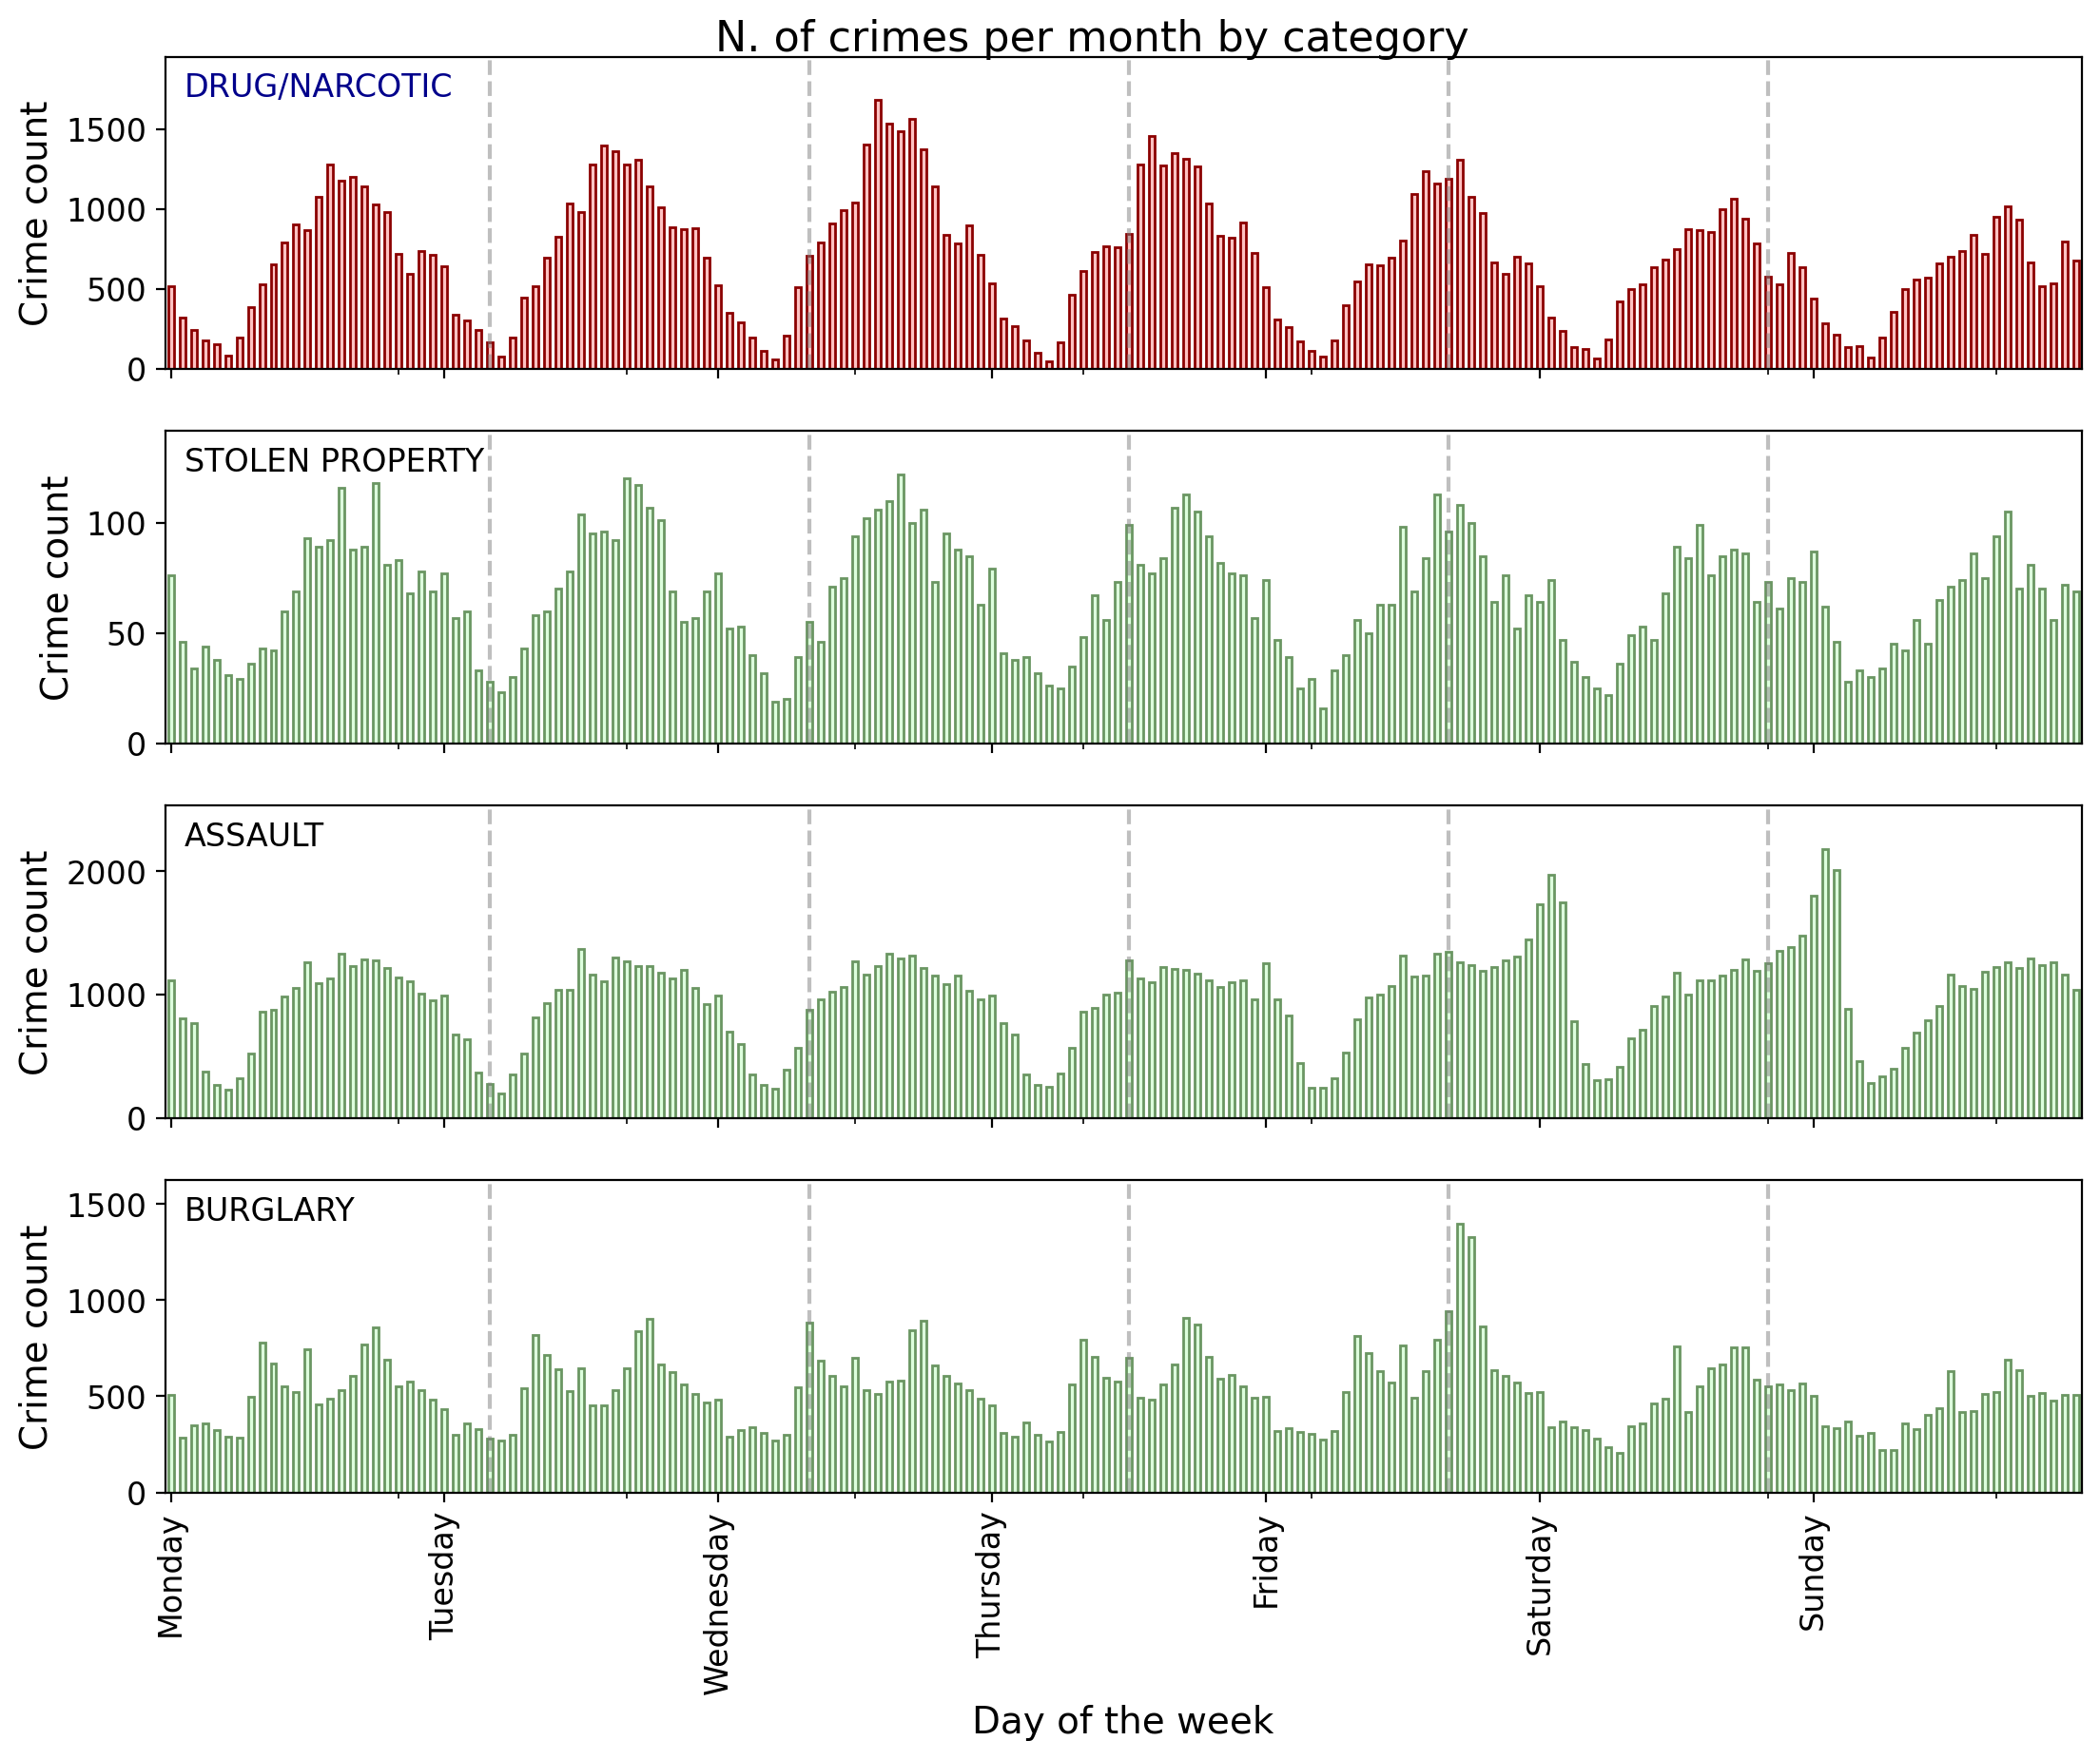

In [11]:
fig, ax = plt.subplots(4,1, figsize=(13,10), dpi=200 , sharex=True, sharey=False)

fig.subplots_adjust(wspace=.3, hspace=.2)  #adjust placing
plt.suptitle('N. of crimes per month by category', fontsize=16, y=0.9)

for index, axes in enumerate(ax.flatten()):
    if related_crimes_list[index] == 'DRUG/NARCOTIC':
        color = '#FFC2C2'
        edgecolor = "#8B0000"
        font_C='Darkblue'
    else:
        color = '#DDFFDD'
        edgecolor = "#6A9662"
        font_C='black'
    ab = df[df['Category'] == related_crimes_list[index]].HourOfWeek.value_counts().sort_index().plot(kind='bar',
                                                                           ax=axes, color=color, edgecolor=edgecolor)
    axes.margins(1,0.16) #side margins
    axes.text(0.01,0.95,related_crimes_list[index],transform=axes.transAxes, va='top', fontsize=12, color=font_C) # text inside plot
    axes.set_xticks(np.arange(0, 168, 24))
    axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_xlabel('Day of the week', fontsize=14)
    axes.set_ylabel('Crime count', fontsize=14)
    for i in range(1,8):
        axes.axvline(x=i*28, color='grey', alpha=0.5, linestyle='--')  # add vertical line after every 24 values on x-axis
fig.patch.set_facecolor('white')



In [15]:
df[df['Category'] == related_crimes_list[index]].HourOfWeek.value_counts().sort_index()

0      505
1      286
2      347
3      360
4      325
      ... 
163    502
164    517
165    476
166    507
167    507
Name: HourOfWeek, Length: 168, dtype: int64

<AxesSubplot:xlabel='HourOfWeek'>

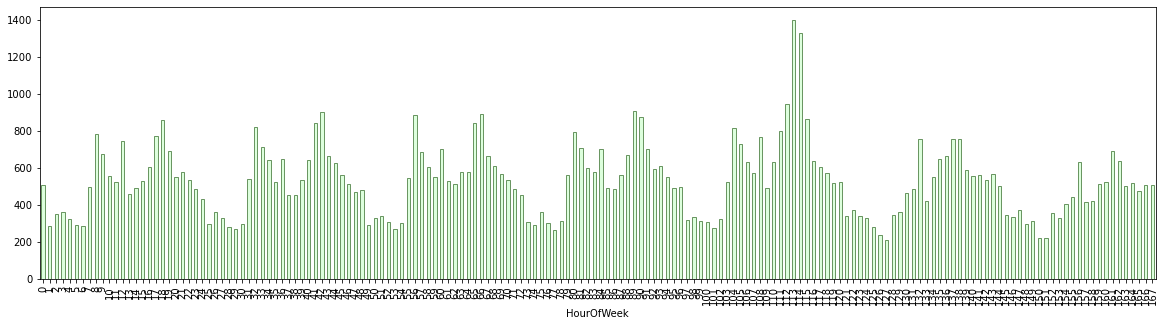

In [28]:
plt.figure(figsize=(20,5))
df_pivot.BURGLARY.plot(kind='bar', color=color, edgecolor=edgecolor)


In [31]:
df_pivot.head(50)


Category,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,LARCENY/THEFT,PROSTITUTION,ROBBERY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WEAPON LAWS
HourOfWeek,,,,,,,,,,,,,,
0,1112,505,63,75,518,92,2122,136,371,76,83,831,589,137
1,808,286,32,77,318,63,1145,81,342,46,60,494,380,89
2,771,347,42,67,244,79,825,64,340,34,60,458,279,91
3,372,360,25,34,177,27,580,48,195,44,39,355,190,58
4,269,325,20,6,154,13,421,36,152,38,32,225,149,36
5,230,288,81,10,81,4,466,38,168,31,111,189,200,21
6,319,285,198,5,195,11,727,51,135,29,226,286,269,38
7,520,498,149,2,383,17,1238,25,111,36,189,397,525,64
8,859,781,109,9,526,20,2029,13,158,43,194,566,752,73


# Exp 2


In [35]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
df_scaled = scaler.fit_transform(df_pivot)

# Convert the scaled data to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_pivot.columns, index=df_pivot.index)
df_scaled

Category,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,LARCENY/THEFT,PROSTITUTION,ROBBERY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WEAPON LAWS
HourOfWeek,,,,,,,,,,,,,,
0,46.041,25.000,23.383,49.324,28.772,40.088,32.183,34.097,43.019,56.604,24.878,50.392,26.961,56.250
1,30.711,6.628,7.960,50.676,16.555,27.313,14.338,20.102,38.312,28.302,13.659,23.940,14.154,33.173
2,28.845,11.745,12.935,43.919,12.034,34.361,8.493,15.776,37.987,16.981,13.659,21.115,7.966,34.135
3,8.724,12.836,4.478,21.622,7.941,11.454,4.018,11.705,14.448,26.415,3.415,13.030,2.512,18.269
4,3.530,9.899,1.990,2.703,6.536,5.286,1.114,8.651,7.468,20.755,0.000,2.826,0.000,7.692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,55.320,24.748,9.453,32.432,37.813,42.291,63.507,7.888,43.669,61.321,33.659,57.378,58.885,64.423
164,52.395,26.007,9.950,25.000,28.589,42.291,58.009,5.598,56.006,50.943,20.488,62.480,68.627,59.615
165,53.707,22.567,11.940,41.892,29.811,38.767,48.384,9.415,58.117,37.736,45.854,68.210,67.402,63.462


In [36]:
related_crimes_list

['DRUG/NARCOTIC', 'STOLEN PROPERTY', 'ASSAULT', 'BURGLARY']

<AxesSubplot:xlabel='HourOfWeek'>

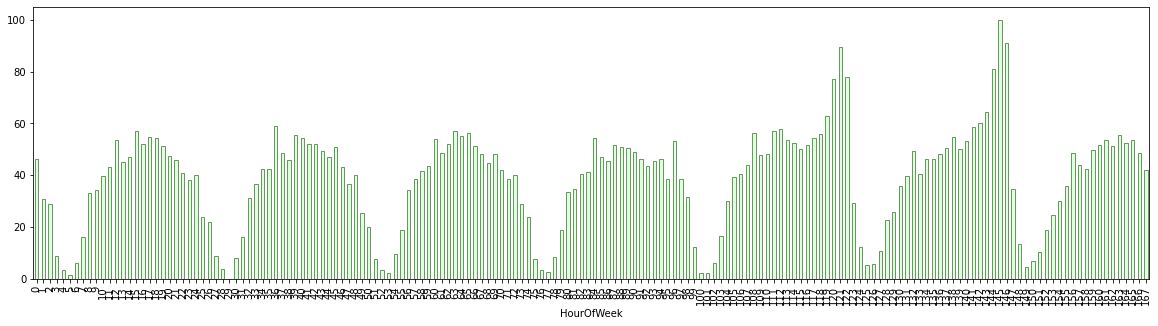

In [38]:
plt.figure(figsize=(20,5))
df_scaled.ASSAULT.plot(kind='bar', color=color, edgecolor=edgecolor)

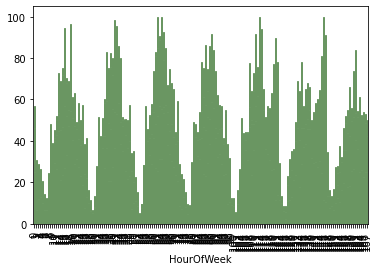

In [40]:
for i in related_crimes_list:
    df_scaled[i].plot(kind='bar', color=color, edgecolor=edgecolor)

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(13,10), dpi=200 , sharex=True, sharey=False)

fig.subplots_adjust(wspace=.3, hspace=.2)  #adjust placing
plt.suptitle('N. of crimes per month by category', fontsize=16, y=0.9)

for index, axes in enumerate(ax.flatten()):
    if related_crimes_list[index] == 'DRUG/NARCOTIC':
        color = '#FFC2C2'
        edgecolor = "#8B0000"
        font_C='Darkblue'
    else:
        color = '#DDFFDD'
        edgecolor = "#6A9662"
        font_C='black'
    ab = df[df['Category'] == related_crimes_list[index]].HourOfWeek.value_counts().sort_index().plot(kind='bar',
                                                                           ax=axes, color=color, edgecolor=edgecolor)
    axes.margins(1,0.16) #side margins
    axes.text(0.01,0.95,related_crimes_list[index],transform=axes.transAxes, va='top', fontsize=12, color=font_C) # text inside plot
    axes.set_xticks(np.arange(0, 168, 24))
    axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_xlabel('Day of the week', fontsize=14)
    axes.set_ylabel('Crime count', fontsize=14)
    for i in range(1,8):
        axes.axvline(x=i*28, color='grey', alpha=0.5, linestyle='--')  # add vertical line after every 24 values on x-axis
fig.patch.set_facecolor('white')


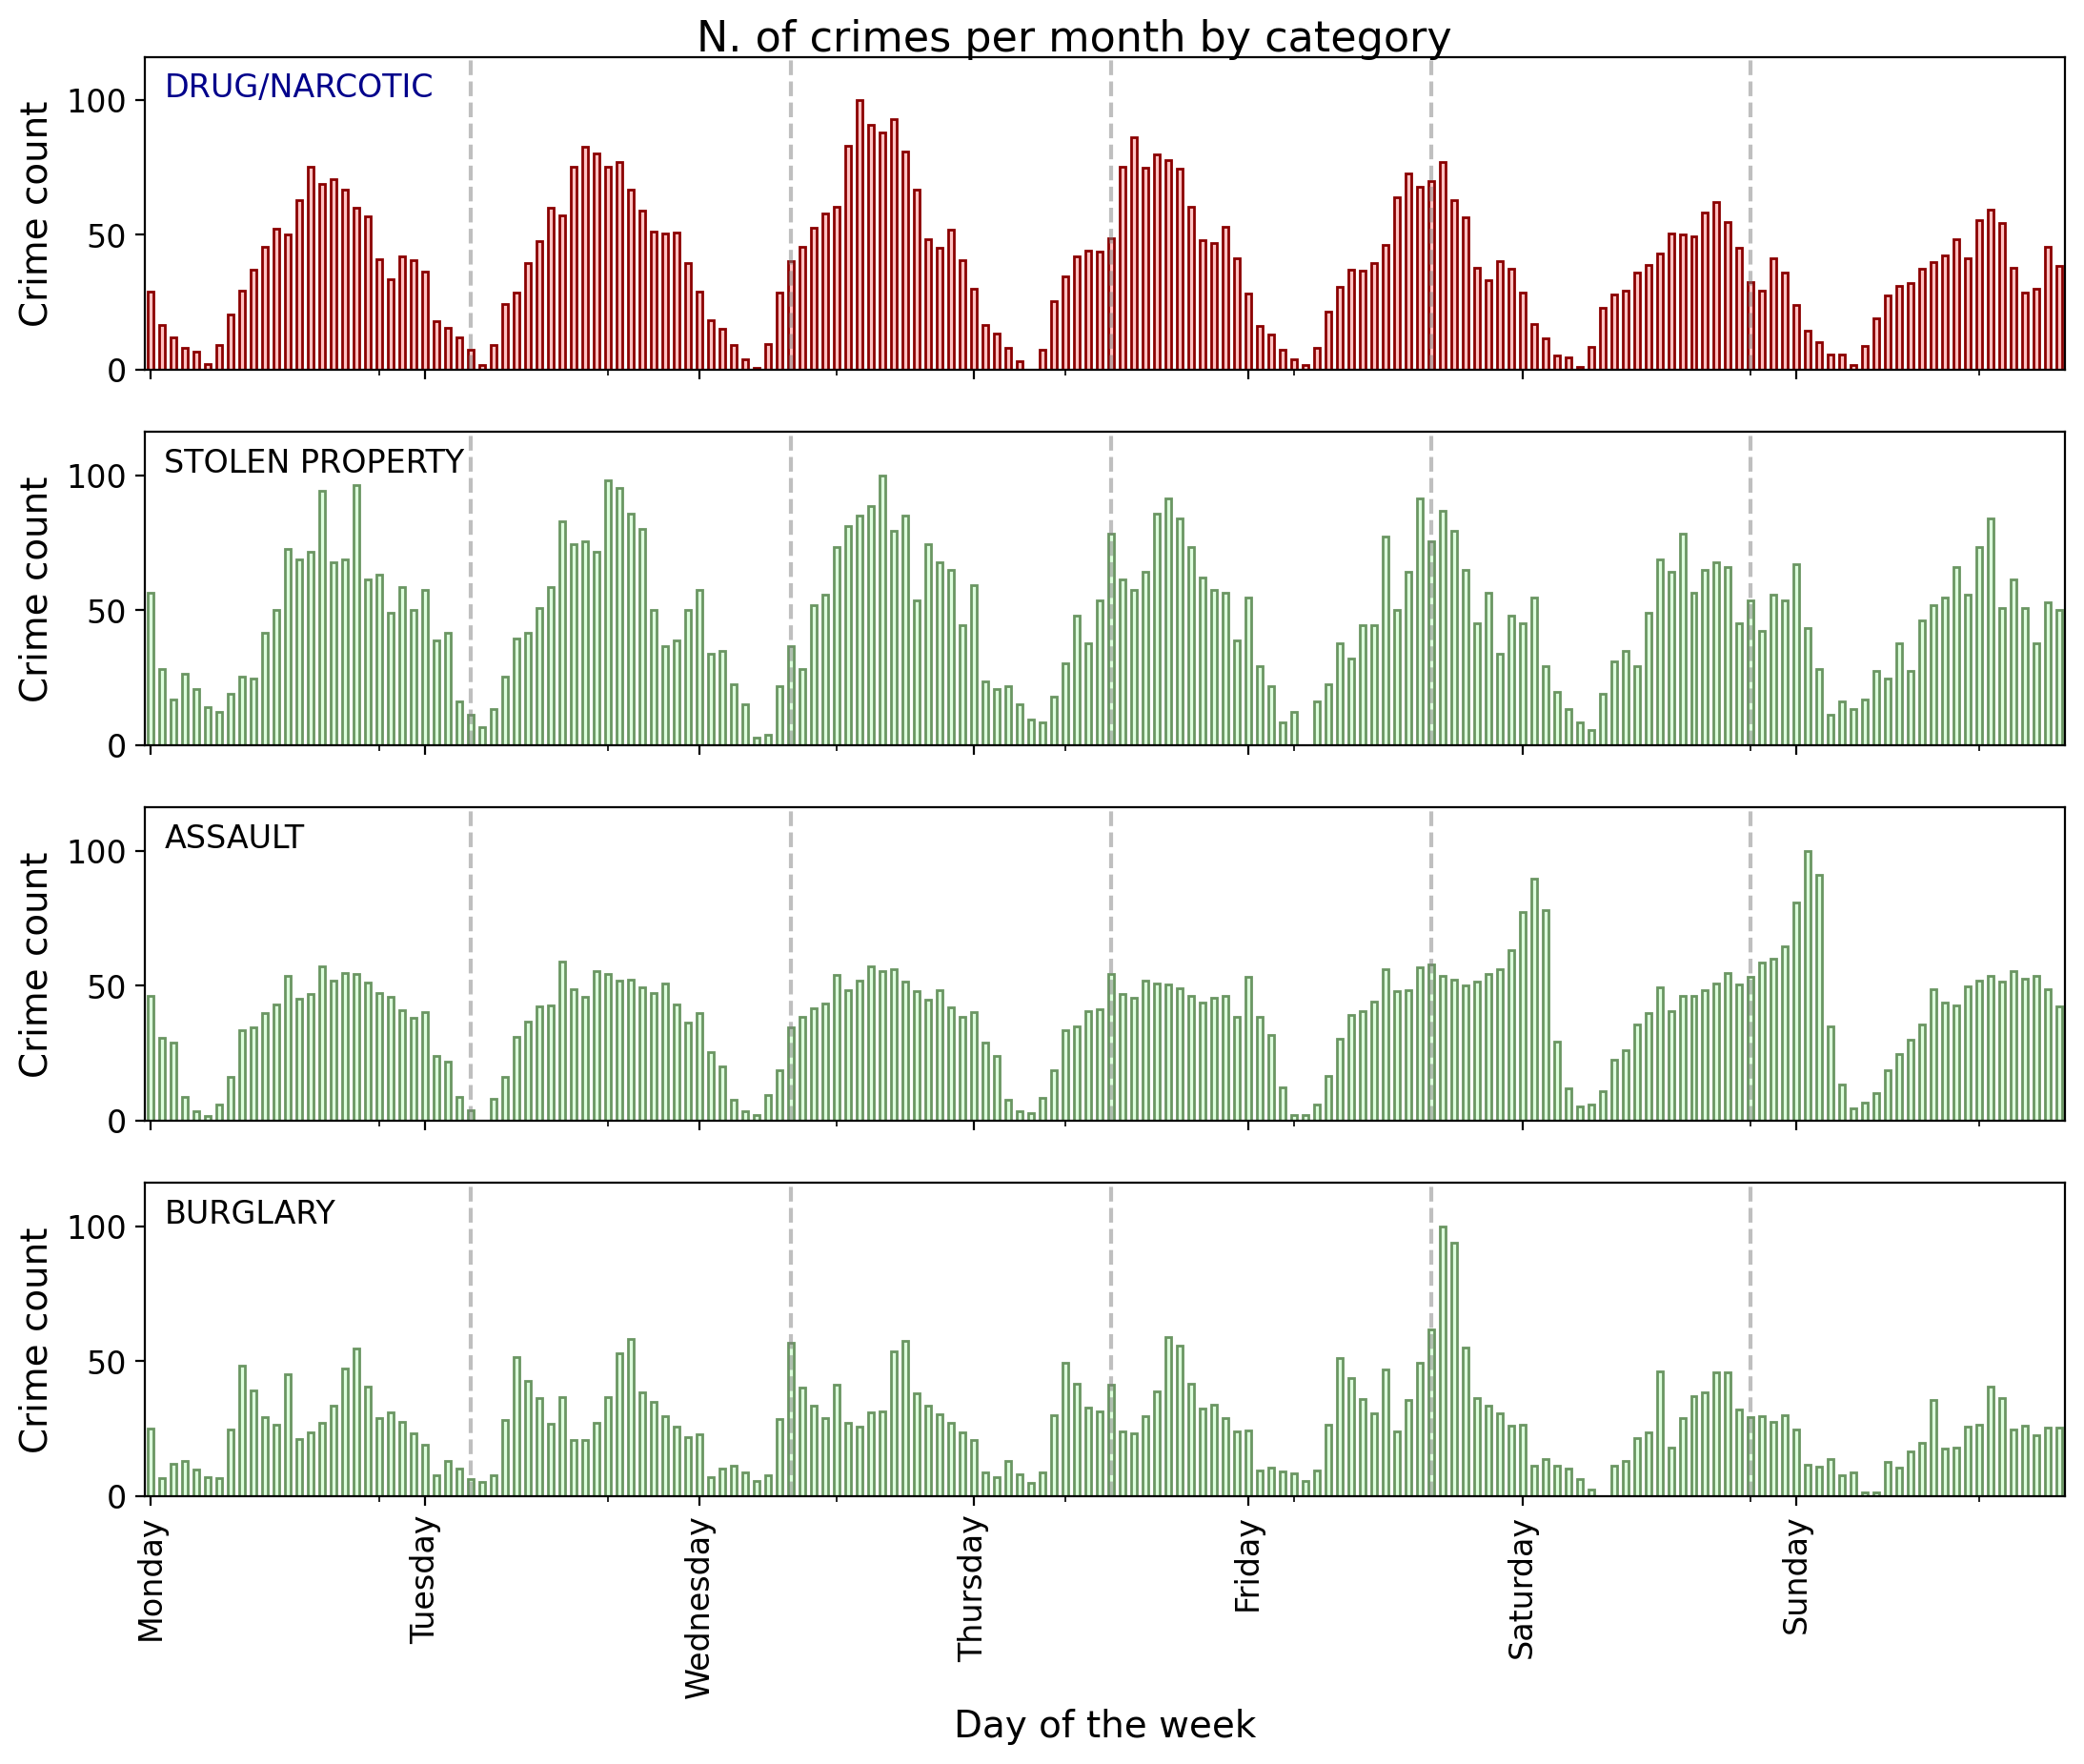

In [51]:
fig, ax = plt.subplots(4,1, figsize=(13,10), dpi=200 , sharex=True, sharey=False)

fig.subplots_adjust(wspace=.3, hspace=.2)  #adjust placing
plt.suptitle('N. of crimes per month by category', fontsize=16, y=0.9)

for index, axes in enumerate(ax.flatten()):
    if related_crimes_list[index] == 'DRUG/NARCOTIC':
        color = '#FFC2C2'
        edgecolor = "#8B0000"
        font_C='Darkblue'
    else:
        color = '#DDFFDD'
        edgecolor = "#6A9662"
        font_C='black'
    cl=related_crimes_list[index]
    ab = df_scaled[cl].plot(kind='bar',ax=axes, color=color, edgecolor=edgecolor)
    
    axes.margins(1,0.16) #side margins
    axes.text(0.01,0.95,related_crimes_list[index],transform=axes.transAxes, va='top', fontsize=12, color=font_C) # text inside plot
    axes.set_xticks(np.arange(0, 168, 24))
    
    axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_xlabel('Day of the week', fontsize=14)
    axes.set_ylabel('Crime count', fontsize=14)
    for i in range(1,8):
        axes.axvline(x=i*28, color='grey', alpha=0.5, linestyle='--')  # add vertical line after every 24 values on x-axis
fig.patch.set_facecolor('white')

# Done above

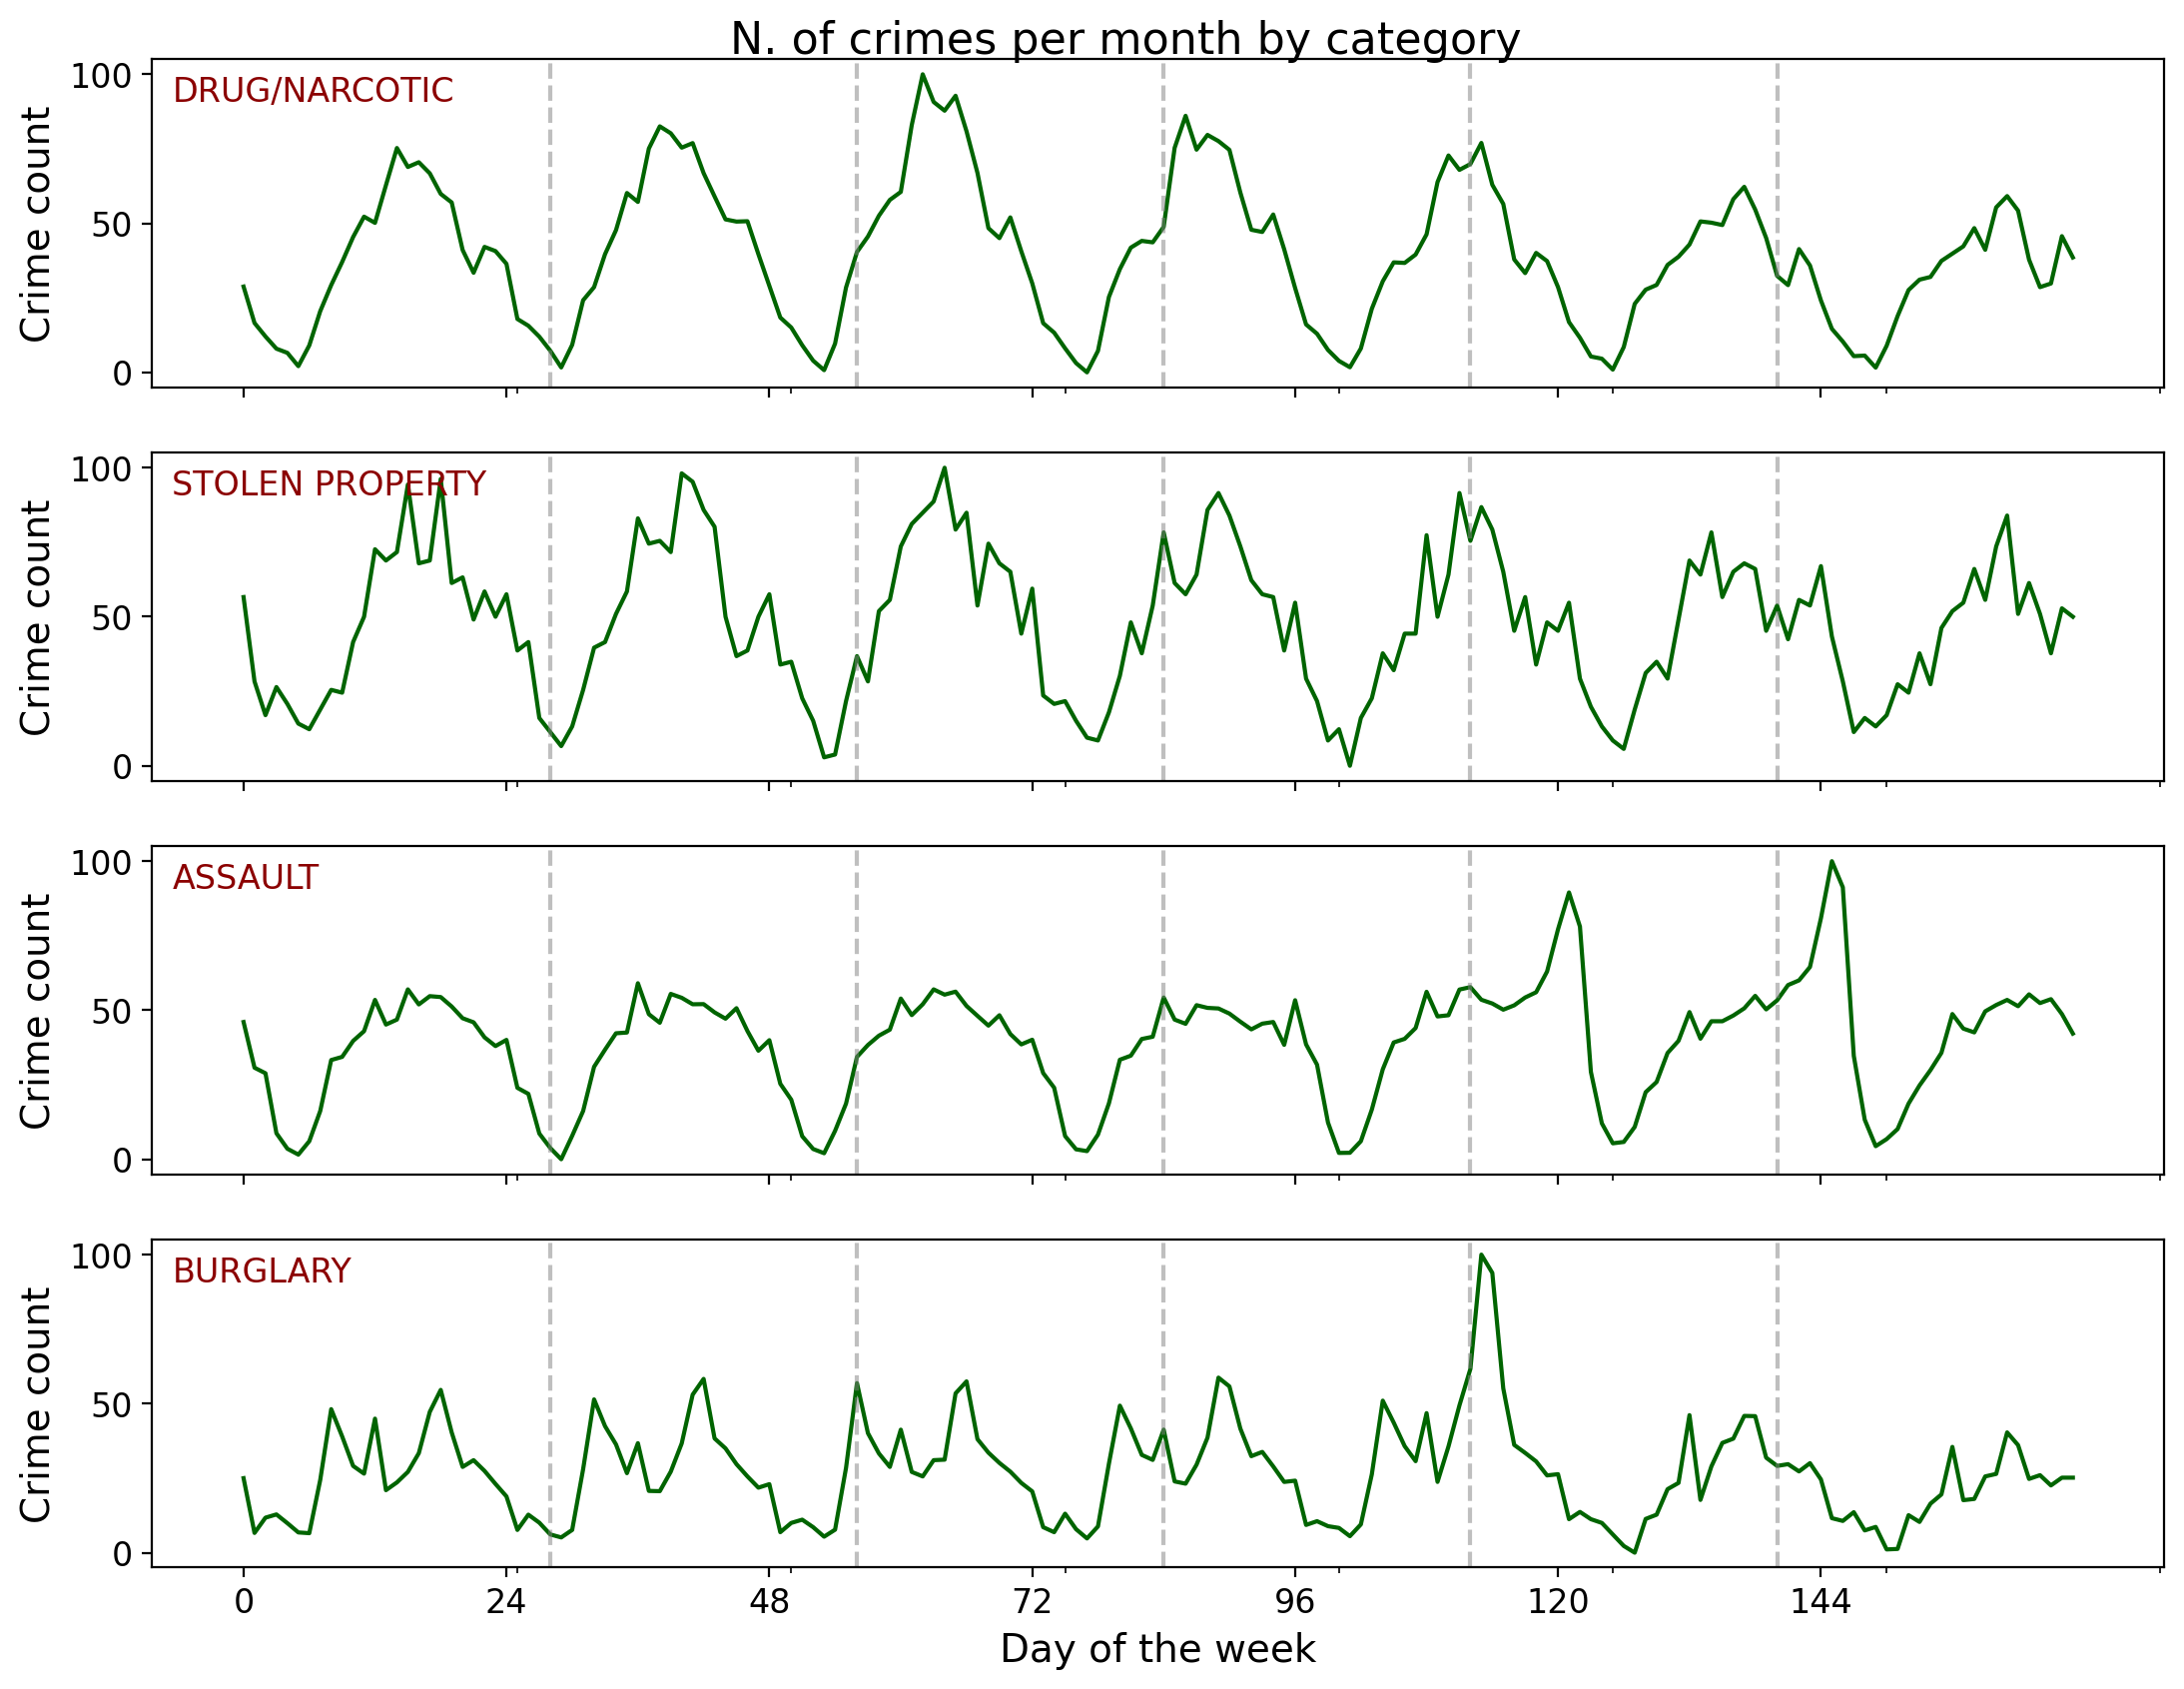

In [90]:
fig, ax = plt.subplots(4,1, figsize=(13,10), dpi=200 , sharex=True, sharey=False)

fig.subplots_adjust(wspace=.3, hspace=.2)  #adjust placing
plt.suptitle('N. of crimes per month by category', fontsize=16, y=0.9)

for index, axes in enumerate(ax.flatten()):
    
    cl=related_crimes_list[index]
    ab = df_scaled[cl].plot(kind='line',ax=axes, color='darkgreen')
    
    #axes.margins(1,0.16) #side margins
    axes.text(0.01,0.95,related_crimes_list[index],transform=axes.transAxes, va='top', fontsize=12, color='#8B0000') # text inside plot
    axes.set_xticks(np.arange(0, 168, 24))
    
    #axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_xlabel('Day of the week', fontsize=14)
    axes.set_ylabel('Crime count', fontsize=14)
    for i in range(1,6):
        axes.axvline(x=i*28, color='grey', alpha=0.5, linestyle='--')  # add vertical line after every 24 values on x-axis
fig.patch.set_facecolor('white')

In [69]:
df_scaled.head(50)

Category,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,LARCENY/THEFT,PROSTITUTION,ROBBERY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WEAPON LAWS
HourOfWeek,,,,,,,,,,,,,,
0,46.041,25.000,23.383,49.324,28.772,40.088,32.183,34.097,43.019,56.604,24.878,50.392,26.961,56.250
1,30.711,6.628,7.960,50.676,16.555,27.313,14.338,20.102,38.312,28.302,13.659,23.940,14.154,33.173
2,28.845,11.745,12.935,43.919,12.034,34.361,8.493,15.776,37.987,16.981,13.659,21.115,7.966,34.135
3,8.724,12.836,4.478,21.622,7.941,11.454,4.018,11.705,14.448,26.415,3.415,13.030,2.512,18.269
4,3.530,9.899,1.990,2.703,6.536,5.286,1.114,8.651,7.468,20.755,0.000,2.826,0.000,7.692
5,1.563,6.795,32.338,5.405,2.077,1.322,1.936,9.160,10.065,14.151,38.537,0.000,3.125,0.481
6,6.051,6.544,90.547,2.027,9.041,4.405,6.703,12.468,4.708,12.264,94.634,7.614,7.353,8.654
7,16.188,24.413,66.169,0.000,20.525,7.048,16.037,5.852,0.812,18.868,76.585,16.327,23.039,21.154
8,33.283,48.154,46.269,4.730,29.261,8.370,30.484,2.799,8.442,25.472,79.024,29.592,36.949,25.481


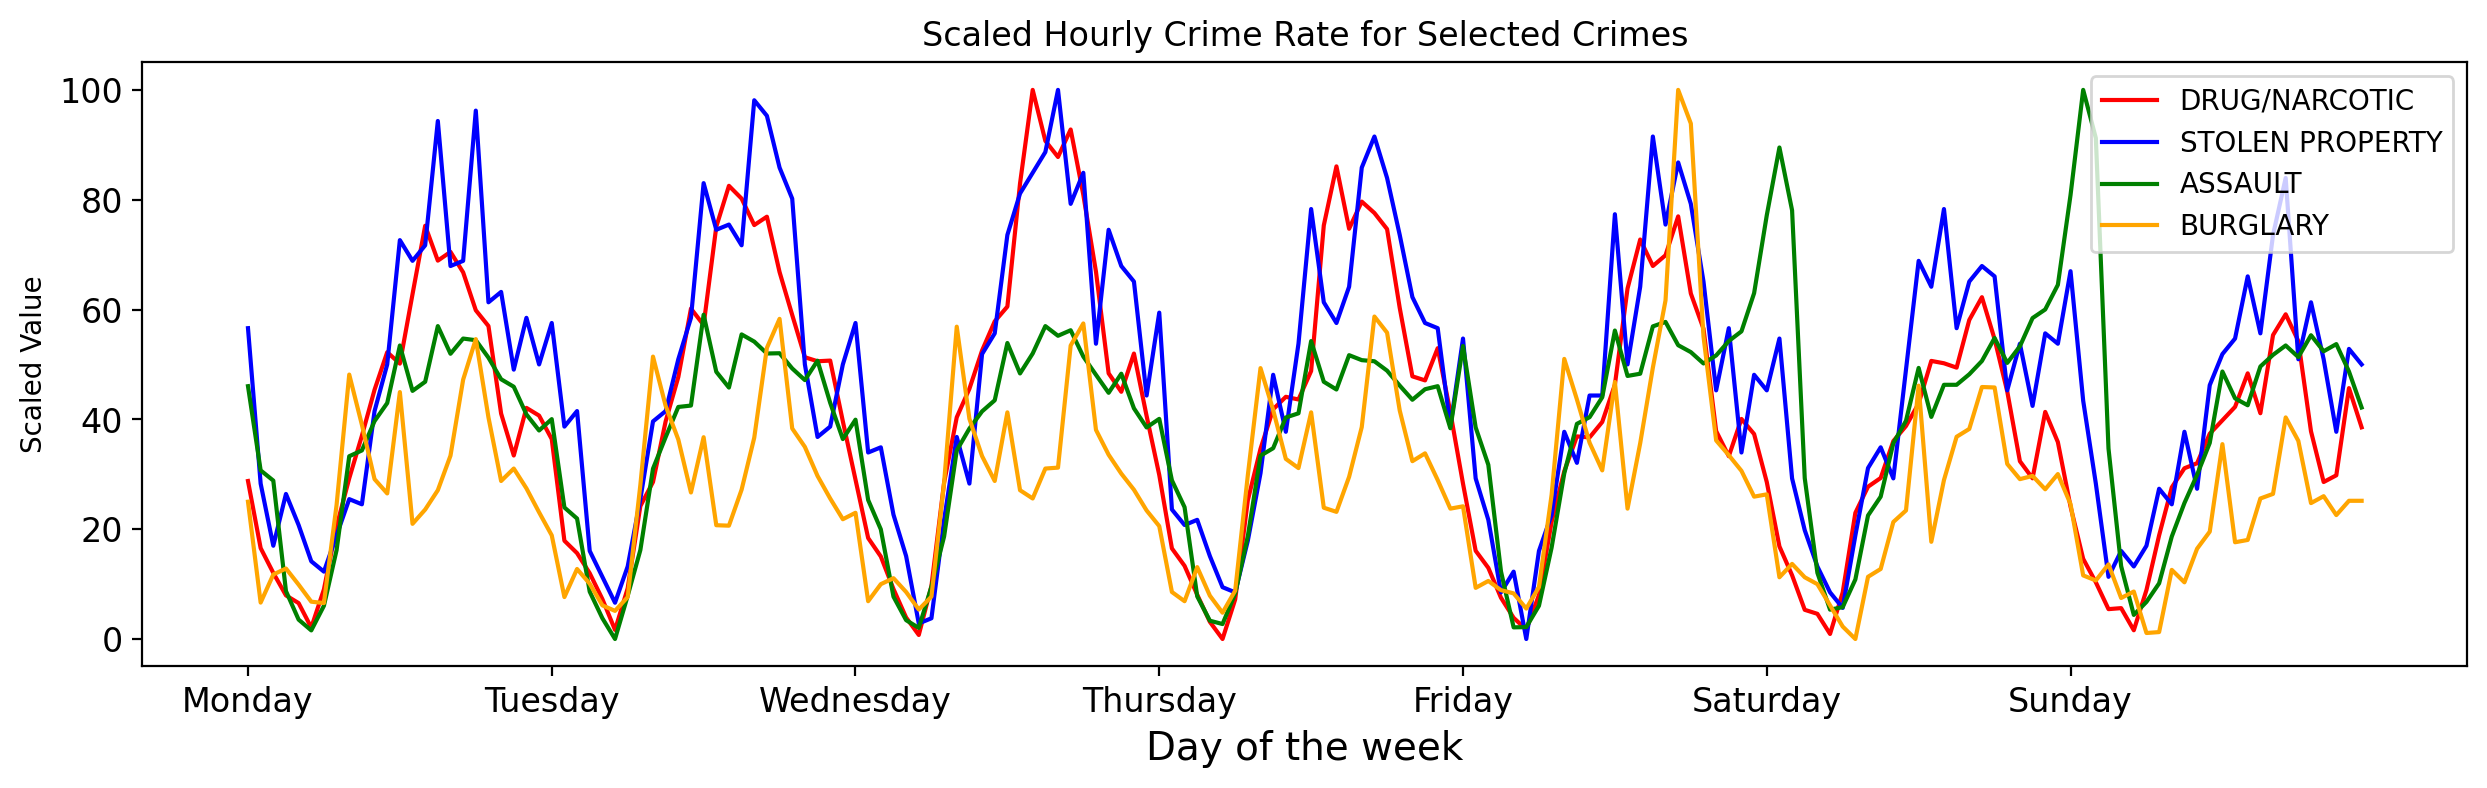

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,4), dpi=200)

colors = ['red', 'blue', 'green', 'orange']

for i, col in enumerate(related_crimes_list):
    df_scaled[col].plot(kind='line', ax=ax, color=colors[i], label=col)

ax.set_xlabel('Hour of Week')
ax.set_ylabel('Scaled Value')
ax.set_title('Scaled Hourly Crime Rate for Selected Crimes')
ax.set_xticks(np.arange(0, 168, 24))
    
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Day of the week', fontsize=14)
ax.legend()

plt.show()


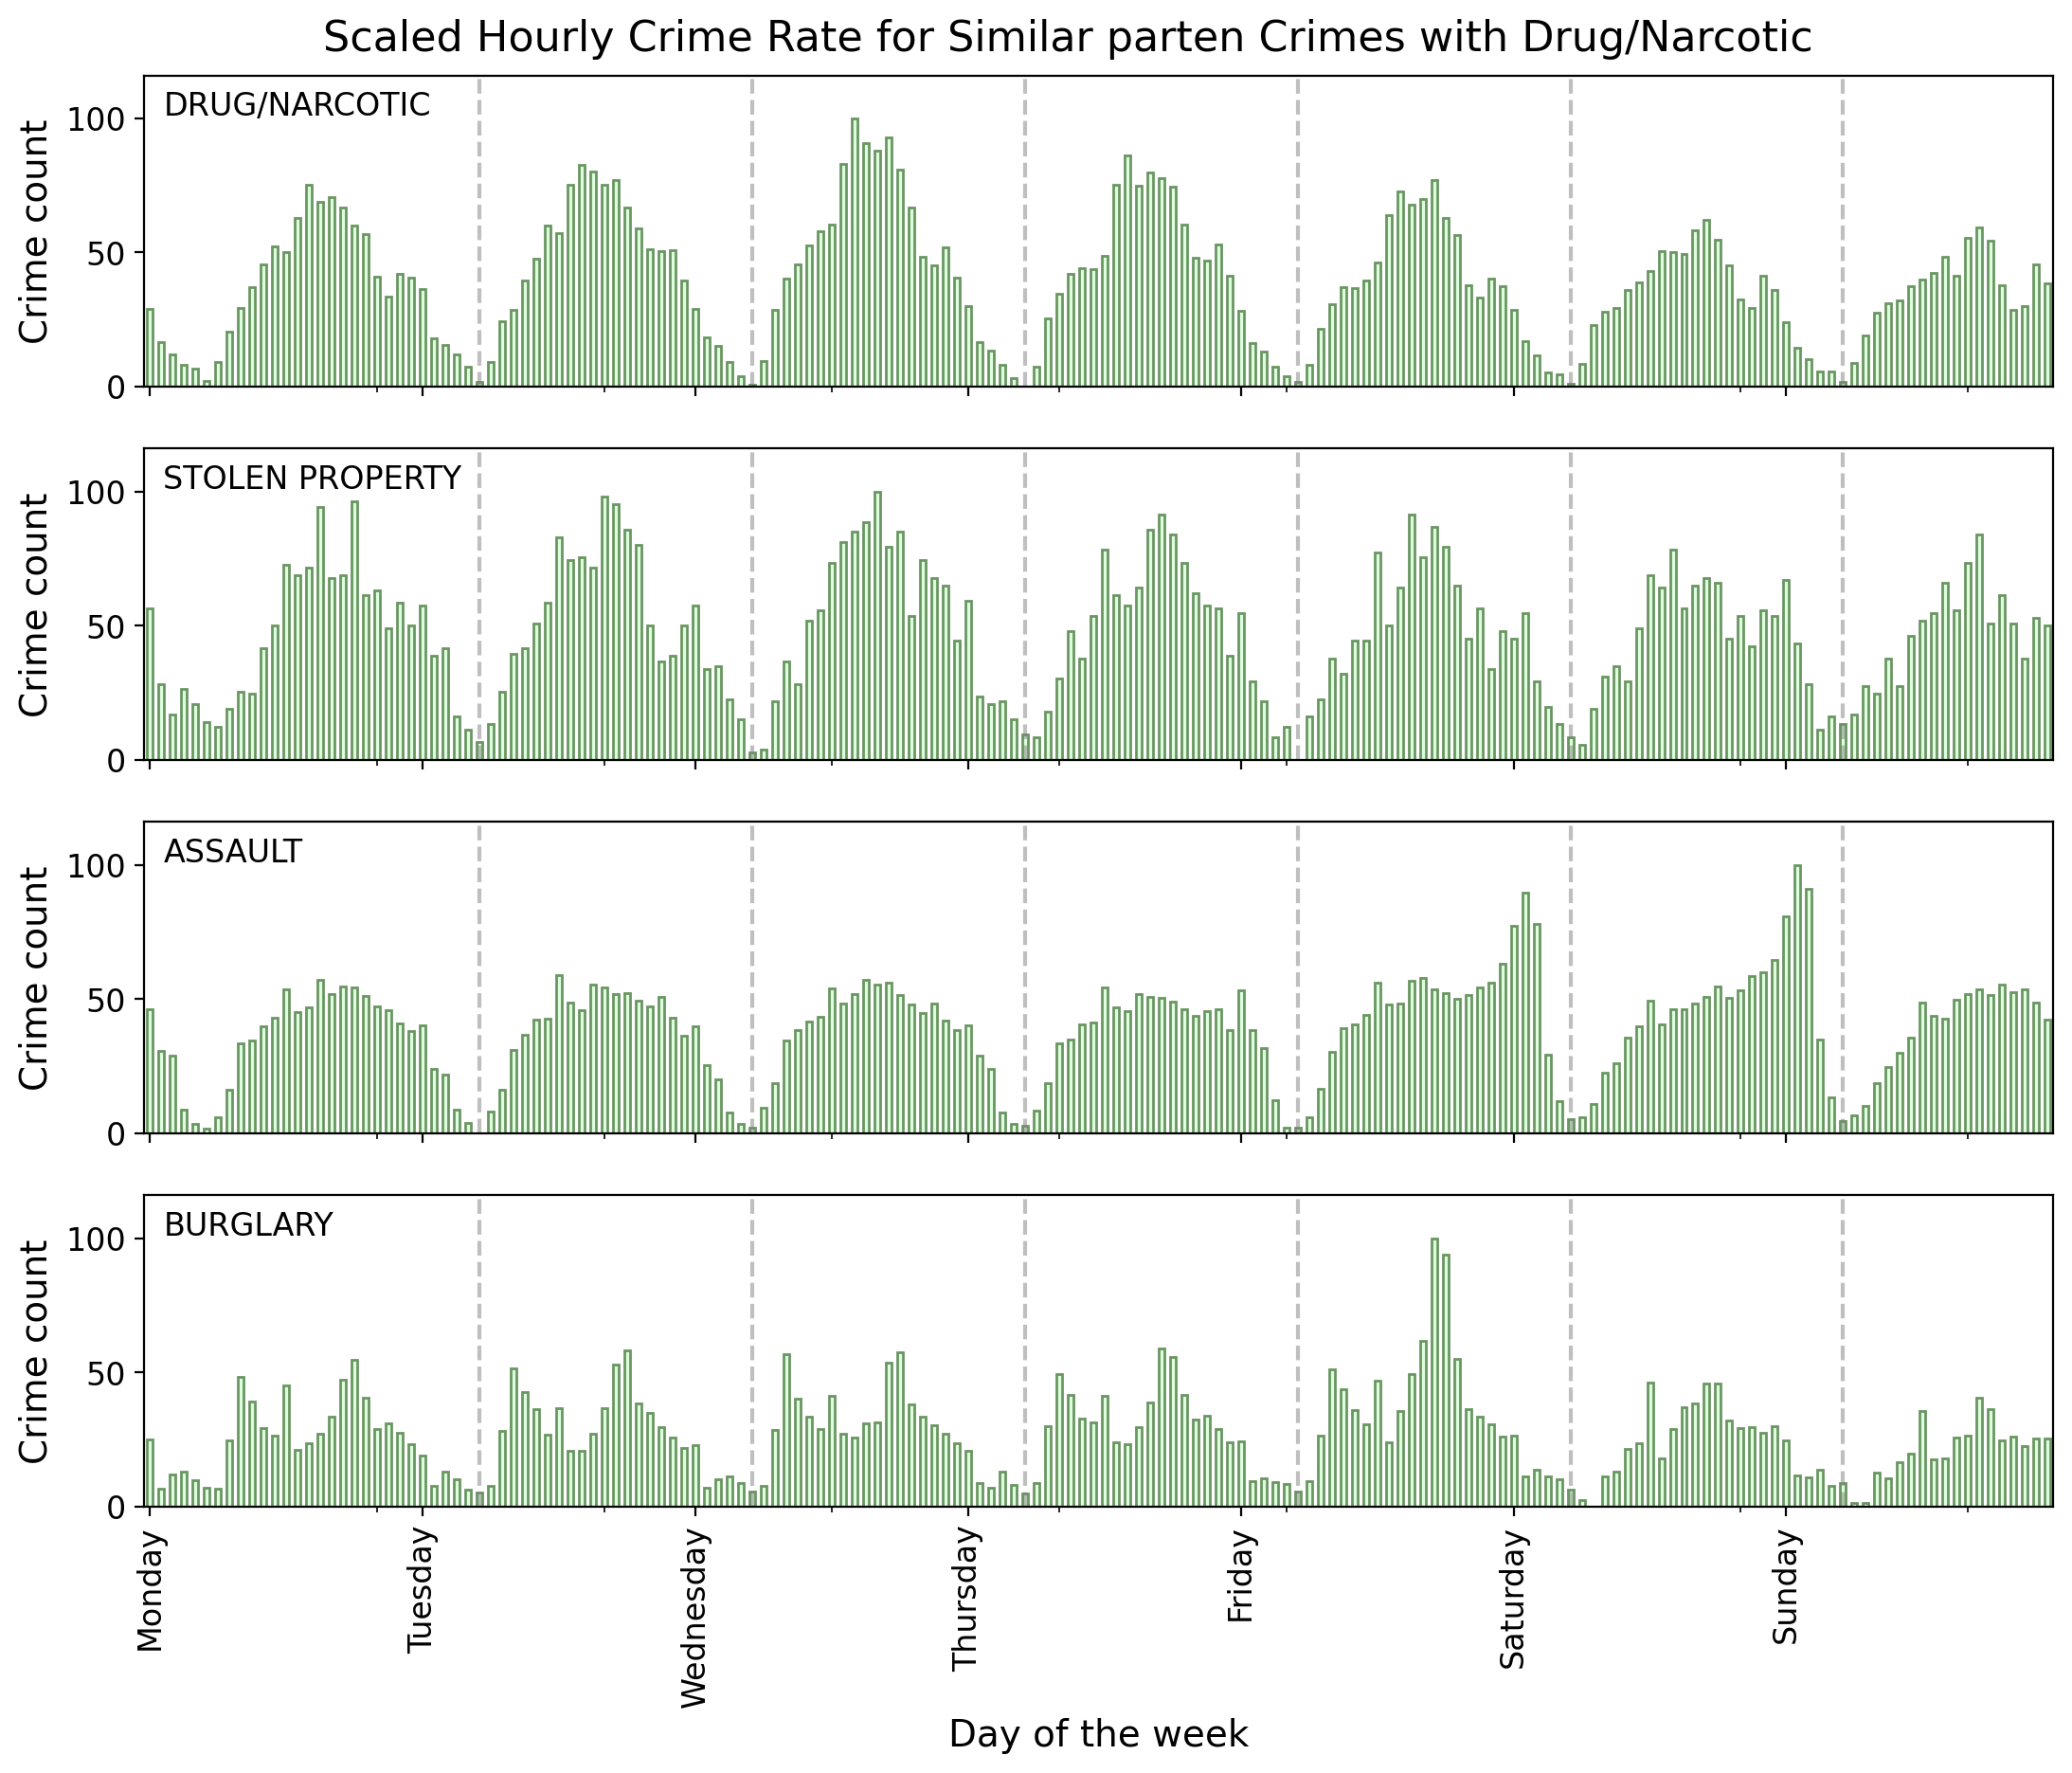

In [116]:
fig, ax = plt.subplots(4,1, figsize=(13,10), dpi=200 , sharex=True, sharey=False)

fig.subplots_adjust(wspace=.3, hspace=.2)  #adjust placing
plt.suptitle('Scaled Hourly Crime Rate for Similar parten Crimes with Drug/Narcotic', fontsize=16, y=0.91)

for index, axes in enumerate(ax.flatten()):

    cl=related_crimes_list[index]
    #df_scaled[cl].plot(kind='line', ax=axes, color='#DDFFDD')
    
    ab = df_scaled[cl].plot(kind='bar',ax=axes, color='#DDFFDD', edgecolor='#6A9662')
    
    axes.margins(1,0.16) #side margins
    axes.text(0.01,0.95,related_crimes_list[index],transform=axes.transAxes, va='top', fontsize=12, color=font_C) # text inside plot
    axes.set_xticks(np.arange(0, 168, 24))
    
    axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_xlabel('Day of the week', fontsize=14)
    axes.set_ylabel('Crime count', fontsize=14)
    for i in np.arange(29, 168, 24):
        axes.axvline(x=i, color='grey', alpha=0.5, linestyle='--')  # add vertical line after every 24 values on x-axis
fig.patch.set_facecolor('white')

In [99]:
np.arange(0, 168, 24)

array([  0,  24,  48,  72,  96, 120, 144])